In [1]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder
from official.vision.configs.common import Augmentation

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline


2024-04-21 19:51:38.395719: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 19:51:40.206548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dino/miniconda3/envs/picar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.16.1


In [5]:
%%bash

IMAGE_DIR="./label_data/images"
TRAIN_ANNOTATION_FILE="./label_data/train.json"
TRAIN_OUTPUT_TFRECORD="./label_data/tfrecords/train"
VALID_ANNOTATION_FILE="./label_data/valid.json"
VALID_OUTPUT_TFRECORD="./label_data/tfrecords/valid"

python -m official.vision.data.create_coco_tf_record --logtostderr \
    --image_dir=${IMAGE_DIR} \
    --object_annotations_file=${TRAIN_ANNOTATION_FILE} \
    --output_file_prefix=${TRAIN_OUTPUT_TFRECORD} \
    --num_shards=1

python -m official.vision.data.create_coco_tf_record --logtostderr \
    --image_dir=${IMAGE_DIR} \
    --object_annotations_file=${VALID_ANNOTATION_FILE} \
    --output_file_prefix=${VALID_OUTPUT_TFRECORD} \
    --num_shards=1

2024-04-21 17:14:06.236842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 17:14:07.024988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-21 17:14:08.702126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:14:08.734455: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:14:08.735512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] co

Error while terminating subprocess (pid=16150): 


2024-04-21 17:14:09.956795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 17:14:10.710756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-21 17:14:12.379412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:14:12.414483: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:14:12.415481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] co

In [6]:
%%bash

IMAGE_DIR="./label_data2/images"
TRAIN_ANNOTATION_FILE="./label_data2/result.json"
TRAIN_OUTPUT_TFRECORD="./label_data2/full"

python -m official.vision.data.create_coco_tf_record --logtostderr \
    --image_dir=${IMAGE_DIR} \
    --object_annotations_file=${TRAIN_ANNOTATION_FILE} \
    --output_file_prefix=${TRAIN_OUTPUT_TFRECORD} \
    --num_shards=1

2024-04-21 17:14:17.778114: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 17:14:18.489421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-21 17:14:20.077570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:14:20.103646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:14:20.103922: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] co

In [3]:
%%bash
python -m official.vision.data.create_coco_tf_record --logtostderr \
    --image_dir="./label_kaggle_training/images" \
    --object_annotations_file="./label_kaggle_training/result.json" \
    --output_file_prefix="./label_kaggle_training/training" \
    --num_shards=1
    
python -m official.vision.data.create_coco_tf_record --logtostderr \
    --image_dir="./label_kaggle_test/images" \
    --object_annotations_file="./label_kaggle_test/result.json" \
    --output_file_prefix="./label_kaggle_test/test" \
    --num_shards=1

2024-04-21 17:06:59.623962: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 17:07:00.306754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-21 17:07:01.853297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:07:01.884525: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:07:01.884917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] co

In [7]:
import tensorflow as tf

# Split the data tfrecord into train and validation

# Define the paths for the input and output tfrecords
input_tfrecord = "./label_data2/full-00000-of-00001.tfrecord"
train_output_tfrecord = "./label_data2/train.tfrecord"
validation_output_tfrecord = "./label_data2/validation.tfrecord"

# Define the split ratio for training and validation data
split_ratio = 0.8  # 80% for training, 20% for validation

# Create a dataset from the input tfrecord
dataset = tf.data.TFRecordDataset(input_tfrecord)

# Count the total number of records in the dataset
num_records = sum(1 for _ in dataset)

# Calculate the number of records for training and validation
num_train_records = int(num_records * split_ratio)
num_validation_records = num_records - num_train_records

# Set random seed
tf.random.set_seed(42)

# Shuffle the dataset
dataset = dataset.shuffle(num_records)

# Split the dataset into training and validation datasets
train_dataset = dataset.take(num_train_records)
validation_dataset = dataset.skip(num_train_records)

# Write the training dataset to the output tfrecord
with tf.io.TFRecordWriter(train_output_tfrecord) as writer:
    for record in train_dataset:
        writer.write(record.numpy())

# Write the validation dataset to the output tfrecord
with tf.io.TFRecordWriter(validation_output_tfrecord) as writer:
    for record in validation_dataset:
        writer.write(record.numpy())

2024-04-21 17:14:46.994047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 17:14:47.934574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-21 17:14:48.850467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:14:48.878767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 17:14:48.878978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] co

In [38]:
# Create combined Training and Validation tfrecords

def combine_tfrecords(input_tfrecord_files, output_tfrecord_file):
    dataset = tf.data.TFRecordDataset(input_tfrecord_files)
    
    # Randomly shuffle the dataset
    tf.random.set_seed(42)
    num_records = sum(1 for _ in dataset)
    dataset = dataset.shuffle(num_records)
    
    with tf.io.TFRecordWriter(output_tfrecord_file) as writer:
        for record in dataset:
            writer.write(record.numpy())
        
training_tfrecord_files = ["./label_data2/train.tfrecord", "./label_kaggle_training/training-00000-of-00001.tfrecord"]
training_output = "./label_data2/train_combined.tfrecord"

combine_tfrecords(training_tfrecord_files, training_output)

validation_tfrecord_files = ["./label_data2/validation.tfrecord", "./label_kaggle_test/test-00000-of-00001.tfrecord"]
validation_output = "./label_data2/validation_combined.tfrecord"

combine_tfrecords(validation_tfrecord_files, validation_output)

2024-04-21 17:52:48.805280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-21 17:52:50.924052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-21 17:52:52.514284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-21 17:52:52.968853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
train_data_path = "./label_data2/train_combined.tfrecord"
valid_data_path = "./label_data2/validation_combined.tfrecord"
#train_data_path = "./label_data2/train.tfrecord"
#valid_data_path = "./label_data2/validation.tfrecord"
model_dir = "./object_detection/trained_models"
export_dir = "./object_detection/exported_models"

In [3]:
exp_config = exp_factory.get_exp_config("retinanet_mobile_coco")
#exp_config = exp_factory.get_exp_config("retinanet_resnetfpn_coco")

In [4]:
batch_size = 8
num_classes = 9

# Multiples of 64 for Resnet and of 128 for Mobilenet? Don't ask...
WIDTH = 384
HEIGHT = 256
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ""

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = (
    exp_config.task.model.num_classes
)

# Training data config.
exp_config.task.train_data.input_path = train_data_path
exp_config.task.train_data.dtype = "float32"
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0
exp_config.task.train_data.parser.aug_rand_hflip = False
# exp_config.task.train_data.parser.pad= False
exp_config.task.train_data.parser.keep_aspect_ratio = False

#exp_config.task.train_data.parser.aug_type = Augmentation(type="autoaug")

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_path
exp_config.task.validation_data.dtype = "float32"
exp_config.task.validation_data.global_batch_size = batch_size
# exp_config.task.validation_data.parser.pad= False
exp_config.task.validation_data.parser.keep_aspect_ratio = False

In [5]:
logical_device_names = [
    logical_device.name for logical_device in tf.config.list_logical_devices()
]

print(logical_device_names)

['/device:CPU:0', '/device:GPU:0']


2024-04-21 19:51:46.874452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 19:51:47.309335: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 19:51:47.309696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 19:51:47.314274: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 19:51:47.314624: I external/local_xla/xla/stream_executor

In [22]:
train_steps = 20000

# Count the number of training images in the training tfrecord file
num_training_images = 0
for record in tf.data.TFRecordDataset(train_data_path):
    num_training_images += 1

num_validation_images = 0
for record in tf.data.TFRecordDataset(valid_data_path):
    num_validation_images += 1

steps_per_loop = num_training_images // batch_size
steps_per_validation = num_validation_images // batch_size

exp_config.trainer.steps_per_loop = steps_per_loop

exp_config.trainer.summary_interval = steps_per_loop
exp_config.trainer.checkpoint_interval = steps_per_loop
exp_config.trainer.validation_interval = steps_per_validation
exp_config.trainer.validation_steps = steps_per_validation
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = steps_per_loop
exp_config.trainer.optimizer_config.learning_rate.type = "cosine"
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

# Save best checkpoint
exp_config.trainer.best_checkpoint_export_subdir = "best_checkpoint"
exp_config.trainer.best_checkpoint_eval_metric = "total_loss"
exp_config.trainer.best_checkpoint_metric_comp = "lower"

# Let's not crash if loss is NaN. Could also do begin_steps but I don't care for it anyway
exp_config.trainer.recovery_max_trials = -1

2024-04-21 20:54:15.269708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-21 20:54:15.769457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
pp.pprint(exp_config.as_dict())

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'float32',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'use_tpu_mp_strategy': False,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'annotation_file': '',
                'differential_privacy_config': None,
      

In [24]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

if "GPU" in "".join(logical_device_names):
    distribution_strategy = tf.distribute.MirroredStrategy()
elif "TPU" in "".join(logical_device_names):
    tf.tpu.experimental.initialize_tpu_system()
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="/device:TPU_SYSTEM:0")
    distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    print("Warning: this will be really slow.")
    distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print("Done")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Done


In [25]:
with distribution_strategy.scope():
    task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

In [26]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
    print()
    print(f"images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}")
    print(f"labels.keys: {labels.keys()}")

In [ ]:
import json
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

json_data = """
{
  "categories": [
    {
      "id": 0,
      "name": "box"
    },
    {
      "id": 1,
      "name": "green_light"
    },
    {
      "id": 2,
      "name": "left_arrow"
    },
    {
      "id": 3,
      "name": "no_light"
    },
    {
      "id": 4,
      "name": "person"
    },
    {
      "id": 5,
      "name": "red_light"
    },
    {
      "id": 6,
      "name": "right_arrow"
    },
    {
      "id": 7,
      "name": "tree"
    },
    {
      "id": 8,
      "name": "unknown_arrow"
    }
  ]
}
"""

data = json.loads(json_data)
categories = data["categories"]

category_index = {category["id"]: category for category in categories}

tf_ex_decoder = TfExampleDecoder(category_index)

In [ ]:
def show_batch(raw_records, num_of_examples):
    plt.figure(figsize=(20, 20))
    use_normalized_coordinates = True
    min_score_thresh = 0.30
    for i, serialized_example in enumerate(raw_records):
        plt.subplot(1, 3, i + 1)
        decoded_tensors = tf_ex_decoder.decode(serialized_example)
        print(decoded_tensors["image"][0])
        image = decoded_tensors["image"].numpy().astype("uint8")
        scores = np.ones(shape=(len(decoded_tensors["groundtruth_boxes"])))
        visualization_utils.visualize_boxes_and_labels_on_image_array(
            image,
            decoded_tensors["groundtruth_boxes"].numpy(),
            decoded_tensors["groundtruth_classes"].numpy().astype("int"),
            scores,
            category_index=category_index,
            use_normalized_coordinates=use_normalized_coordinates,
            max_boxes_to_draw=200,
            min_score_thresh=min_score_thresh,
            agnostic_mode=False,
            instance_masks=None,
            line_thickness=4,
        )

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image-{i+1}")
    plt.show()

tf.Tensor(
[[ 31  26  28]
 [ 30  25  27]
 [ 20  20  20]
 [ 62  62  62]
 [ 32  35  30]
 [ 32  35  30]
 [ 28  28  26]
 [ 23  24  21]
 [ 44  26  23]
 [ 64  46  43]
 [ 62  47  41]
 [ 62  47  41]
 [ 59  50  50]
 [ 61  52  53]
 [ 61  55  64]
 [ 65  59  68]
 [ 64  60  52]
 [ 67  64  56]
 [ 70  65  55]
 [ 69  64  54]
 [ 71  53  61]
 [ 68  51  59]
 [ 62  55  55]
 [ 70  63  63]
 [ 71  70  66]
 [ 75  73  69]
 [ 86  70  70]
 [ 82  66  67]
 [ 75  66  67]
 [ 74  65  65]
 [ 75  65  69]
 [ 74  64  68]
 [ 79  61  74]
 [ 79  61  74]
 [ 69  66  74]
 [ 68  64  72]
 [ 67  61  72]
 [ 63  56  67]
 [ 50  48  58]
 [  9   8  17]
 [ 44  38  45]
 [ 54  49  55]
 [ 47  55  62]
 [  0   2   8]
 [146 151 186]
 [218 224 255]
 [183 208 247]
 [180 206 245]
 [171 191 251]
 [168 188 247]
 [155 177 237]
 [145 167 228]
 [140 160 219]
 [127 147 206]
 [129 145 199]
 [127 143 197]
 [129 145 203]
 [123 139 197]
 [129 130 194]
 [143 144 208]
 [116 124 171]
 [  3  11  58]
 [  0   8  22]
 [ 49  63  77]
 [ 41  66  94]
 [ 44  69  97]

2024-04-21 19:51:59.847165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


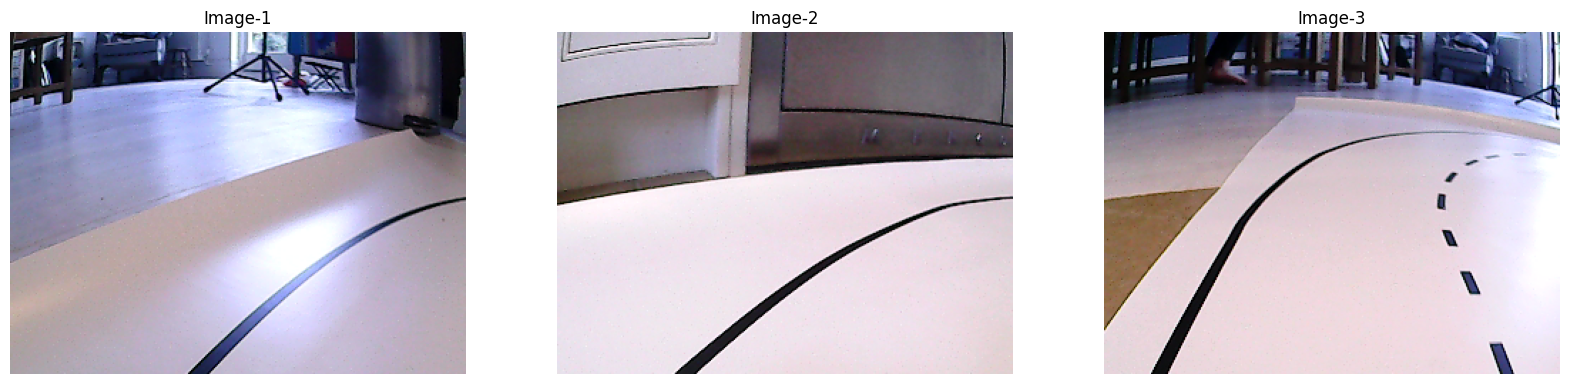

In [ ]:
buffer_size = 20
num_of_examples = 3

raw_records = (
    tf.data.TFRecordDataset(exp_config.task.train_data.input_path)
    .shuffle(buffer_size=buffer_size)
    .take(num_of_examples)
)
show_batch(raw_records, num_of_examples)

In [ ]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode="train_and_eval",
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True,
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


restoring or initializing model...
restored model from ./object_detection/trained_models/ckpt-136.
restored from checkpoint: ./object_detection/trained_models/ckpt-136
train | step:    136 | training until step 272...


2024-04-21 19:54:07.755600: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


train | step:    272 | steps/sec:    0.8 | output: 
    {'box_loss': 0.010562557,
     'cls_loss': 1.25039,
     'learning_rate': 0.03966722,
     'model_loss': 1.7785177,
     'total_loss': 2.093779,
     'training_loss': 2.093779}
 eval | step:    272 | running 136 steps of evaluation...


2024-04-21 19:59:30.174338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-21 19:59:30.174534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.93s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

2024-04-21 20:03:50.406696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-21 20:03:50.407001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.86s).
Accumulating evaluation results...
DONE (t=0.91s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

2024-04-21 20:08:24.902150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-21 20:08:24.902319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

2024-04-21 20:12:51.480450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-21 20:12:51.480808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Av

2024-04-21 20:17:22.001244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-21 20:17:22.001762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.38s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Av

2024-04-21 20:21:54.304355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-21 20:21:54.304483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.92s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.033
 Av

2024-04-21 20:25:37.629320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-21 20:25:37.629601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.69s).
Accumulating evaluation results...
DONE (t=0.85s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
 Av

2024-04-21 20:28:59.470490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-21 20:28:59.470637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.75s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
 Av

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './object_detection/trained_models'

Reusing TensorBoard on port 6006 (pid 15314), started 40 days, 1:59:59 ago. (Use '!kill 15314' to kill it.)

In [ ]:
export_saved_model_lib.export_inference_graph(
    input_type="image_tensor",
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir,
)

INFO:tensorflow:Assets written to: ./object_detection/exported_models/assets


INFO:tensorflow:Assets written to: ./object_detection/exported_models/assets


In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if path.startswith("http"):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, "rb").read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    return (
        np.array(image.getdata()).reshape((1, im_height, im_width, 3)).astype(np.uint8)
    )


def build_inputs_for_object_detection(image, input_image_size):
    """Builds Object Detection model inputs for serving."""
    image, _ = resize_and_crop_image(
        image,
        input_image_size,
        padded_size=input_image_size,
        aug_scale_min=1.0,
        aug_scale_max=1.0,
    )
    return image

In [ ]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures["serving_default"]

(-0.5, 383.5, 255.5, -0.5)

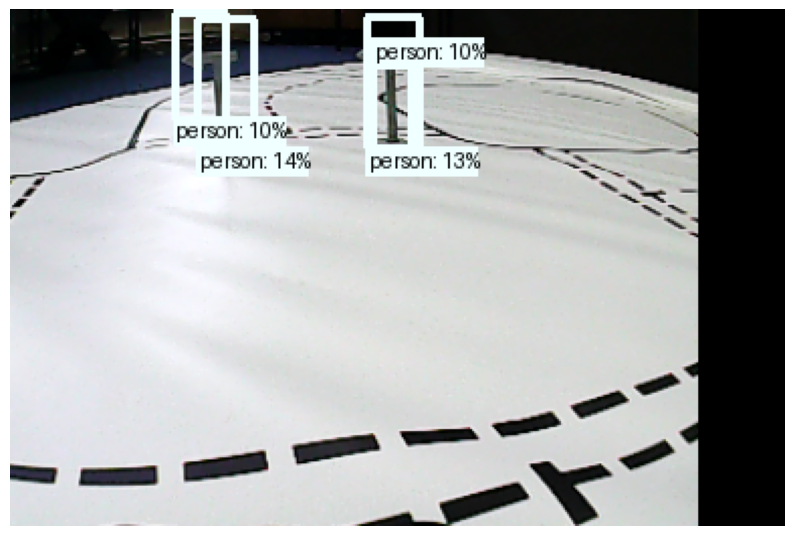

In [ ]:
input_image_size = [HEIGHT, WIDTH]
plt.figure(figsize=(10, 10))
min_score_thresh = 0.1

image_np = load_image_into_numpy_array(
    "label_kaggle_test/images/0a18836a-702.png"
)
image = build_inputs_for_object_detection(image_np[0], input_image_size)
image = tf.expand_dims(image, axis=0)
image = tf.cast(image, dtype=tf.uint8)
image_np = image[0].numpy()

result = model_fn(image)

visualization_utils.visualize_boxes_and_labels_on_image_array(
    image_np,
    result["detection_boxes"][0].numpy(),
    result["detection_classes"][0].numpy().astype(int),
    result["detection_scores"][0].numpy(),
    category_index=category_index,
    use_normalized_coordinates=False,
    max_boxes_to_draw=200,
    min_score_thresh=min_score_thresh,
    agnostic_mode=False,
    instance_masks=None,
    line_thickness=4,
)
plt.imshow(image_np)
plt.axis("off")